## Predicting Influencers in Social Networks
 #### *a graph-based machine learning project*

In [1]:
import pandas as pd
import numpy as np
import igraph as ig
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt

### What is Reddit?

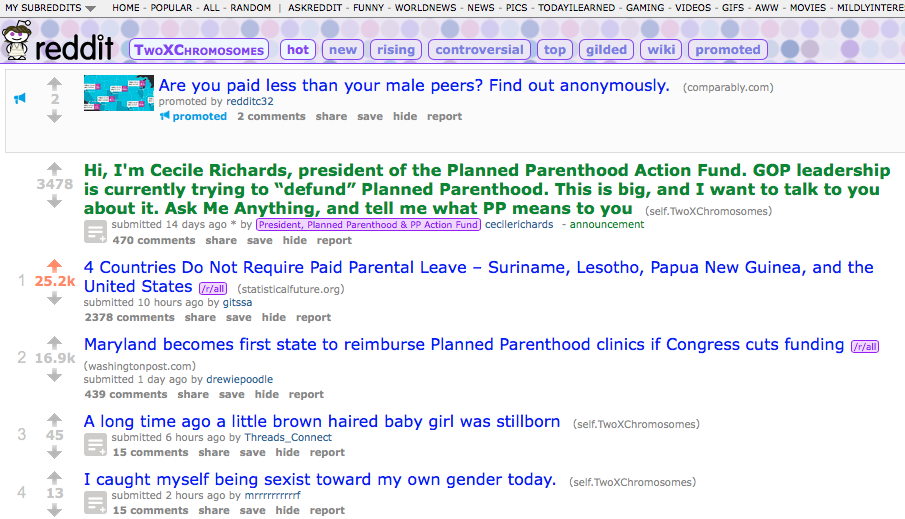

In [2]:
from IPython.display import Image
Image("img/reddit.png")

### Who are Influencers?


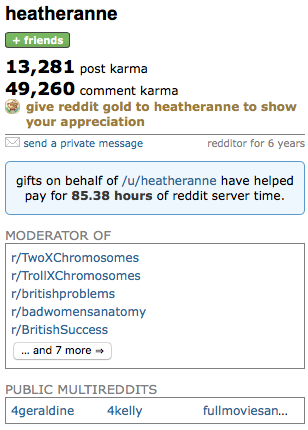

In [3]:
from IPython.display import Image
Image("img/karma.png")

### Let's pick a subreddit...

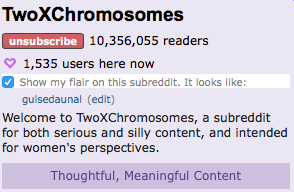

In [4]:
from IPython.display import Image
Image("img/twoX.png")

### Data 

Reddit public comments datasets are available on Google Big Query

In [5]:
y2016m01 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_01.csv', sep=',',  header=0)
y2016m02 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_02.csv', sep=',',  header=0)
y2016m03 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_03.csv', sep=',',  header=0)
y2016m04 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_04.csv', sep=',',  header=0)
y2016m05 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_05.csv', sep=',',  header=0)
y2016m06 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_06.csv', sep=',',  header=0)
y2016m07 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_07.csv', sep=',',  header=0)
y2016m08 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_08.csv', sep=',',  header=0)
y2016m09 = pd.read_csv('TwoXChromosomesDatasets/twox_2016_09.csv', sep=',',  header=0)

#### Train and Test Datasets

In [6]:
train_dfs = pd.concat([y2016m01, y2016m02, y2016m03])
test_dfs = pd.concat([y2016m04,y2016m05, y2016m06, y2016m07, y2016m08, y2016m09])
dfs = pd.concat([y2016m01, y2016m02, y2016m03, y2016m04, y2016m05, y2016m06, y2016m07, y2016m08, y2016m09])

In [7]:
train_dfs['pid'] = train_dfs.parent_id.apply(lambda x: x.split('_')[1] if '_' in x else x)
train_dfs['lid'] = train_dfs.link_id.apply(lambda x: x.split('_')[1] if '_' in x else x)
test_dfs['pid'] = test_dfs.parent_id.apply(lambda x: x.split('_')[1] if '_' in x else x)
test_dfs['lid'] = test_dfs.link_id.apply(lambda x: x.split('_')[1] if '_' in x else x)
dfs['pid'] = dfs.parent_id.apply(lambda x: x.split('_')[1] if '_' in x else x)
dfs['lid'] = dfs.link_id.apply(lambda x: x.split('_')[1] if '_' in x else x)

#### Train and Test Networks (Graphs)

##### How the network structure is in Reddit comments

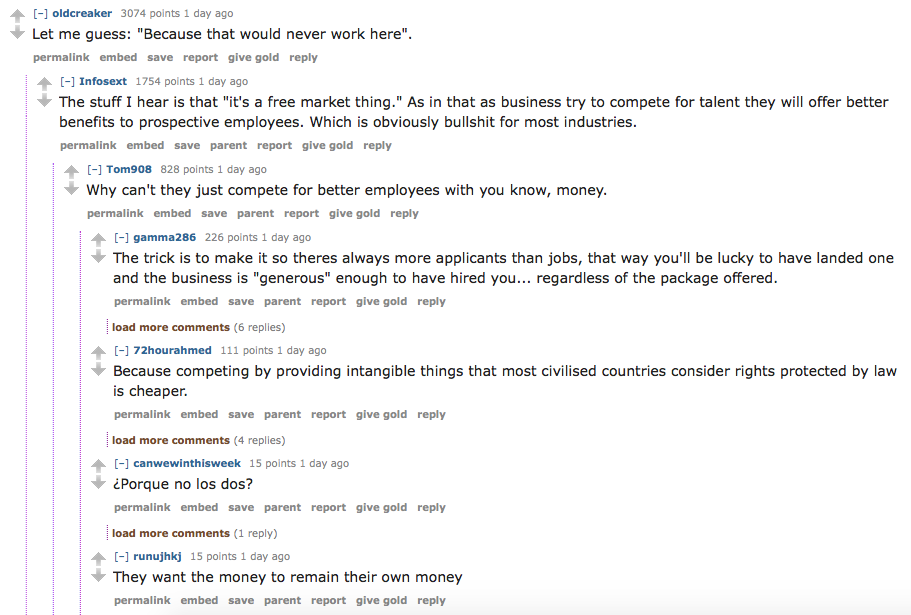

In [8]:
from IPython.display import Image
Image("img/redditnet.png")

In [9]:
def create_net(df):
    '''src -> source node
    tgt - target node'''
    df = df[~(df['author'].str.contains("[deleted]"))].copy() 
    '''a deep copy, including a copy of the data and the indices 
    actual python objects will not be copied recursively, only the reference to the object'''
    # NODES
    vertices_data  = df.groupby(['author'])['score'].sum()
    g = ig.Graph(directed=True)
    g.add_vertices(vertices_data.index)
    g.vs['score'] = vertices_data.values
    # EDGES
    ndf = pd.merge(df,df,left_on='id',right_on='pid',how='inner',suffixes=['_p','_c'])[['author_c','author_p','score_c','score_p']].sort('author_c').rename(columns = {'author_c':'src','author_p':'tgt','score_c':'src_score','score_p':'tgt_score'})
    g.add_edges(ndf[['src','tgt']].values)
    g.es['weight'] = 1 #create the weight attribute and determine that all edges have weight 1
    g.simplify(combine_edges='sum') #simplifying network by combining parallel edges and removing self-loops
    # When I combine the parallel edges sum up the edge weights : the weight is going to be the number of interactions between users
    return g.vs.select(_degree_gt=0).subgraph()
# zero degree nodes byebye

test_g = create_net(test_dfs)
train_g = create_net(train_dfs)

##### How graphs look like

In [10]:
print 'Train Graph', train_g.summary()
print 'Test Graph', test_g.summary() 

Train Graph IGRAPH DNW- 1409 1484 -- 
+ attr: name (v), score (v), weight (e)
Test Graph IGRAPH DNW- 2823 3163 -- 
+ attr: name (v), score (v), weight (e)


#### Data for Graph-based Machine Learning

##### Network Centrality Measures 

In [11]:
from sklearn.preprocessing import scale
'''Normalizing data
For many estimators, including the SVMs, having datasets 
with unit standard deviation for each feature is important to get good prediction.'''

net_test_data = pd.DataFrame(
    {'name':test_g.vs['name'],
     'betw':scale(test_g.betweenness(weights='weight')),
     'pr':scale(test_g.pagerank(weights='weight')),
     'ind':scale(test_g.degree(mode='in')),
     'outd':scale(test_g.degree(mode='out')),
     'dgree':test_g.degree(mode='ALL'),
     'closeness':scale(test_g.closeness(weights='weight')),
     'score':scale(test_g.vs['score']),
     'inf_flag':(np.array(test_g.vs['score'])>=np.percentile(test_g.vs['score'],95)).astype('int')
    }
)

net_train_data = pd.DataFrame(
    {'name':train_g.vs['name'],
     'betw':scale(train_g.betweenness(weights='weight')),
     'pr':scale(train_g.pagerank(weights='weight')),
     'ind':scale(train_g.degree(mode='in')),
     'outd':scale(train_g.degree(mode='out')),
     'dgree':train_g.degree(mode='ALL'),
     'closeness':scale(train_g.closeness(weights='weight')),
     'score':scale(train_g.vs['score']),
     'inf_flag':(np.array(train_g.vs['score'])>=np.percentile(train_g.vs['score'],95)).astype('int')
    }
)
# scale for gaussian dfs zero mean unit variance 
# http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

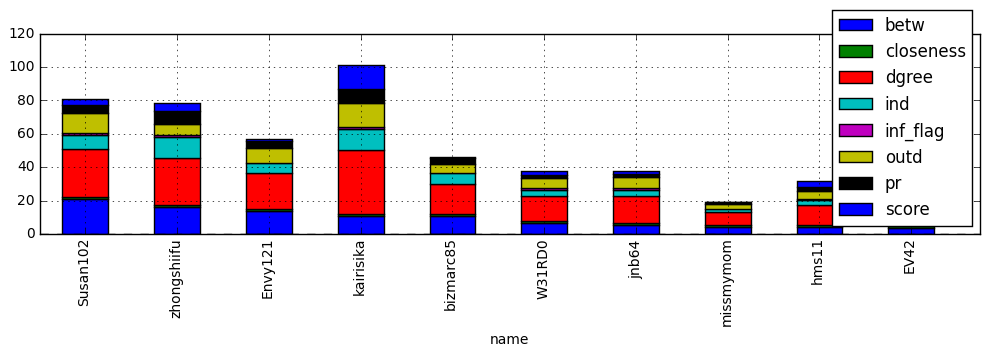

In [12]:
df = net_train_data.sort(['betw'],ascending=False).head(10)

df.plot(kind = 'bar', stacked= True, fontsize = 10,\
            subplots = False,yticks=None, figsize=(10,3.5), \
                     x = df['name'], legend = True)

plt.tight_layout()

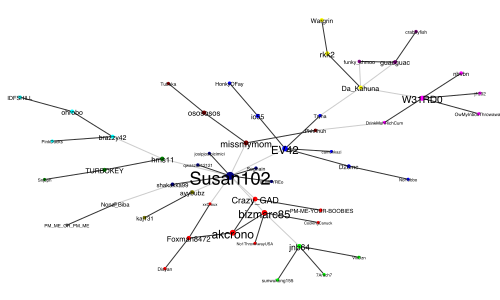

In [13]:
g3 = train_g.components().giant().as_undirected(combine_edges='sum')
pagerank = g3.pagerank(weights='weight')
cmm = g3.community_walktrap(weights='weight')
ig.plot(cmm.as_clustering(), 'subreddit.pdf', bbox=[500, 300],
        vertex_size=ig.rescale(pagerank,out_range=(3,8)),
        vertex_label_size=ig.rescale(pagerank,out_range=(4,18)),
        vertex_label=g3.vs['name'],
        vertex_frame_width=0)

##### Supervised Learning

In [14]:
X_train = net_train_data[['betw','ind','outd','pr']].values
Y_train = net_train_data['inf_flag'].values
X_test = net_test_data[['betw','ind','outd','pr']].values
Y_test = net_test_data['inf_flag'].values

### SVM

In [15]:
from sklearn import svm
from sklearn.metrics import mean_squared_error
from math import sqrt

clf = svm.SVC(kernel='linear')
print 'as it is'
y_predicted = clf.fit(X_train, Y_train).predict(X_test)
print 'training score', clf.score(X=X_train,y=Y_train)
print 'test score', clf.score(X=X_test,y=Y_test) 
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted))

as it is
training score 0.951029098652
test score 0.952886999646
rms 0.217055293311


[[2680    1]
 [ 132   10]]


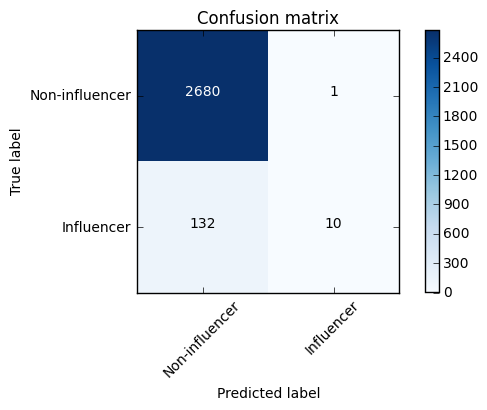

In [16]:
class_names = ['Non-influencer','Influencer']
import itertools

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] ### to normalize
 
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_predicted)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)
#Plot normalized confusion matrix



plt.show()

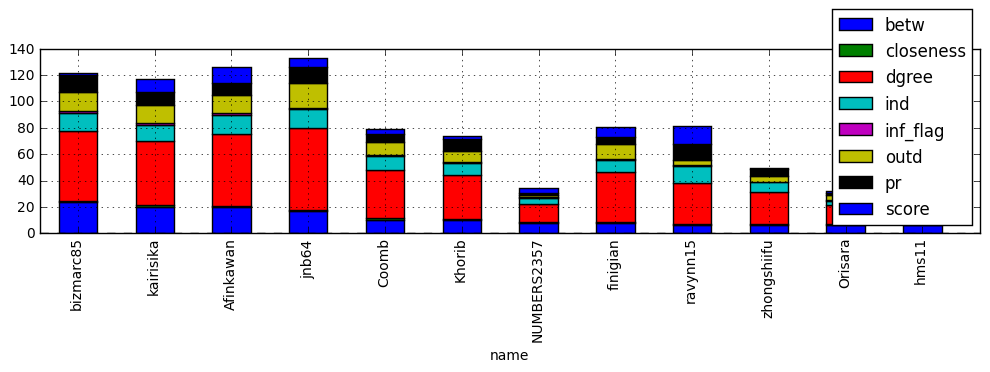

In [17]:
df = net_test_data.sort(['betw'],ascending=False).head(12)

df.plot(kind = 'bar', stacked= True, fontsize = 10,\
            subplots = False,yticks=None, figsize=(10,3.5), \
                     x = df['name'], legend = True)

plt.tight_layout()

In [18]:
g3 = test_g.components().giant().as_undirected(combine_edges='sum')
pagerank = g3.pagerank(weights='weight')
cmm = g3.community_walktrap(weights='weight')
ig.plot(cmm.as_clustering(), 'subreddit2.pdf', bbox=[600, 400],
        vertex_size=ig.rescale(pagerank,out_range=(1,5)),
        vertex_label_size=ig.rescale(pagerank,out_range=(1,20)),
        vertex_label=g3.vs['name'],
        vertex_frame_width=0)

In [19]:
for i in range(len(Y_train)):
    if Y_train[[i]]==0:
        Y_train[[i]] = -1


b = np.ones(Y_train.shape)*Y_train
XY = np.matrix.transpose(np.matrix.transpose(X_train)*b)
S = np.column_stack((XY,b))

for i in range(len(Y_test)):
    if Y_test[[i]]==0:
        Y_test[[i]] = -1
        
'''train'''
tMax = 9000
C = .01
m = len(X_train)
rowsx,colsx = S.shape
a = np.zeros(colsx)
lambd = 1/(C*m)

for t in range(tMax):
    index = np.random.choice(range(m)) #random index
    yk = S[index]
    multp = np.linalg.norm(np.multiply(yk, a), ord=1)
    if multp <= lambd*t:
        a = a + yk
    else:
        a = a
    wt = a/(lambd*t)      
    
'''test'''
bres = wt[len(wt)-1]
supvec = wt[0:-1]
Ypred = np.zeros(Y_test.shape)
infList = list()
for ind in range(len(Y_test)):
    Xcurr = X_test[ind]
    sgn = np.sign(np.add(np.linalg.norm(np.multiply(Xcurr, supvec),ord=1),bres))
    Ypred[[ind]]=sgn
    if sgn==1:
        infList.append(ind)
    

In [20]:
net_test_data.ix[infList,'name']

171        Afinkawan
374            Coomb
712         JJMcgray
755          Juko007
789           Khorib
1004     NUMBERS2357
1075         Orisara
1364    Shuh_nay_nay
1415        Susan102
1521          Tisias
1760         aniIIop
1832       bizmarc85
1983        finigian
2008          funchy
2079           hms11
2181           jnb64
2219       kairisika
2243      kinkakinka
2549        ravynn15
2805     zhongshiifu
2818     zugzwang_03
Name: name, dtype: object

#### Possible Correlation in X

##### Pearson Correlation Coefficient

In [21]:
from scipy.stats.stats import pearsonr    
print 'betweenness vs. pagerank', pearsonr(net_train_data['betw'], net_train_data['pr'])
print 'betweenness vs. in-degree',pearsonr(net_train_data['betw'], net_train_data['ind'])
print 'betweenness vs. out-degree',pearsonr(net_train_data['betw'], net_train_data['outd'])
print 'in-degree vs. out-degree',pearsonr(net_train_data['ind'], net_train_data['outd'])

betweenness vs. pagerank (0.39248494889620394, 4.1804102815080743e-53)
betweenness vs. in-degree (0.64675052146481793, 9.7627345166613626e-168)
betweenness vs. out-degree (0.70740109097335224, 2.8096472993063766e-214)
in-degree vs. out-degree (0.59724644783570269, 5.8663104068626702e-137)


#### Principal Component Analysis

In [22]:
from sklearn.decomposition import PCA
Xtrain_reduced = PCA(n_components=3).fit_transform(X_train)
Xtest_reduced = PCA(n_components=3).fit_transform(X_test)
clf = svm.SVC(kernel='linear')
print 'after PCA'
y_predicted3 = clf.fit(Xtrain_reduced, Y_train).predict(Xtest_reduced)
rms = sqrt(mean_squared_error(Y_test, y_predicted3))
print 'training score', clf.score(X=Xtrain_reduced,y=Y_train)
print 'test score', clf.score(X=Xtest_reduced,y=Y_test)
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted3))

after PCA
training score 0.950319375444
test score 0.95253276656
rms 0.435739525128


In [23]:
Xtrain_reduced2 = PCA(n_components=2).fit_transform(X_train)
Xtest_reduced2 = PCA(n_components=2).fit_transform(X_test)
clf = svm.SVC(kernel='linear')
print 'after PCA 2nd'
y_predicted2 = clf.fit(Xtrain_reduced2, Y_train).predict(Xtest_reduced2)
rms = sqrt(mean_squared_error(Y_test, y_predicted2))
print 'training score', clf.score(X=Xtrain_reduced2,y=Y_train)
print 'test score', clf.score(X=Xtest_reduced2,y=Y_test)
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted2))

after PCA 2nd
training score 0.949609652236
test score 0.949698901877
rms 0.4485581261


In [24]:
from sklearn.preprocessing import scale
'''Normalizing data
For many estimators, including the SVMs, having datasets 
with unit standard deviation for each feature is important to get good prediction.'''

net_test_data = pd.DataFrame(
    {'name':test_g.vs['name'],
     'betw':scale(test_g.betweenness(weights='weight')),
     'pr':scale(test_g.pagerank(weights='weight')),
     'ind':scale(test_g.degree(mode='in')),
     'outd':scale(test_g.degree(mode='out')),
     'dgree':test_g.degree(mode='ALL'),
     'closeness':scale(test_g.closeness(weights='weight')),
     'score':scale(test_g.vs['score']),
     'inf_flag':(np.array(test_g.vs['score'])>=np.percentile(test_g.vs['score'],97.5)).astype('int')
    }
)

net_train_data = pd.DataFrame(
    {'name':train_g.vs['name'],
     'betw':scale(train_g.betweenness(weights='weight')),
     'pr':scale(train_g.pagerank(weights='weight')),
     'ind':scale(train_g.degree(mode='in')),
     'outd':scale(train_g.degree(mode='out')),
     'dgree':train_g.degree(mode='ALL'),
     'closeness':scale(train_g.closeness(weights='weight')),
     'score':scale(train_g.vs['score']),
     'inf_flag':(np.array(train_g.vs['score'])>=np.percentile(train_g.vs['score'],97.5)).astype('int')
    }
)

X_train = net_train_data[['betw','ind','outd','pr']].values
Y_train = net_train_data['inf_flag'].values
X_test = net_test_data[['betw','ind','outd','pr']].values
Y_test = net_test_data['inf_flag'].values

from sklearn import svm
from sklearn.metrics import mean_squared_error
from math import sqrt

clf = svm.SVC(kernel='linear')
print 'as it is'
y_predicted = clf.fit(X_train, Y_train).predict(X_test)
print 'training score', clf.score(X=X_train,y=Y_train)
print 'test score', clf.score(X=X_test,y=Y_test) #sklearn.metrics.accuracy_score(Y_test, y_predicted, normalize=True, sample_weight=None)
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted))


as it is
training score 0.974449964514
test score 0.974849450939
rms 0.158589246361


#### Closeness as a Feature

In [25]:
from sklearn.preprocessing import scale
'''Normalizing data
For many estimators, including the SVMs, having datasets 
with unit standard deviation for each feature is important to get good prediction.'''

net_test_data = pd.DataFrame(
    {'name':test_g.vs['name'],
     'betw':scale(test_g.betweenness(weights='weight')),
     'pr':scale(test_g.pagerank(weights='weight')),
     'ind':scale(test_g.degree(mode='in')),
     'outd':scale(test_g.degree(mode='out')),
     'dgree':test_g.degree(mode='ALL'),
     'closeness':scale(test_g.closeness(weights='weight')),
     'score':scale(test_g.vs['score']),
     'inf_flag':(np.array(test_g.vs['score'])>=np.percentile(test_g.vs['score'],97.5)).astype('int')
    }
)

net_train_data = pd.DataFrame(
    {'name':train_g.vs['name'],
     'betw':scale(train_g.betweenness(weights='weight')),
     'pr':scale(train_g.pagerank(weights='weight')),
     'ind':scale(train_g.degree(mode='in')),
     'outd':scale(train_g.degree(mode='out')),
     'dgree':train_g.degree(mode='ALL'),
     'closeness':scale(train_g.closeness(weights='weight')),
     'score':scale(train_g.vs['score']),
     'inf_flag':(np.array(train_g.vs['score'])>=np.percentile(train_g.vs['score'],97.5)).astype('int')
    }
)

X_train = net_train_data[['betw','dgree','closeness','pr']].values
Y_train = net_train_data['inf_flag'].values
X_test = net_test_data[['betw','dgree','closeness','pr']].values
Y_test = net_test_data['inf_flag'].values

from sklearn import svm
from sklearn.metrics import mean_squared_error
from math import sqrt

clf = svm.SVC(kernel='linear')
print 'as it is'
y_predicted = clf.fit(X_train, Y_train).predict(X_test)
print 'training score', clf.score(X=X_train,y=Y_train)
print 'test score', clf.score(X=X_test,y=Y_test) #sklearn.metrics.accuracy_score(Y_test, y_predicted, normalize=True, sample_weight=None)
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted))



as it is
training score 0.974449964514
test score 0.974849450939
rms 0.158589246361


### Only betweenness 

In [26]:
from sklearn.preprocessing import scale
'''Normalizing data
For many estimators, including the SVMs, having datasets 
with unit standard deviation for each feature is important to get good prediction.'''

net_test_data = pd.DataFrame(
    {'name':test_g.vs['name'],
     'betw':scale(test_g.betweenness(weights='weight')),
     'pr':scale(test_g.pagerank(weights='weight')),
     'ind':scale(test_g.degree(mode='in')),
     'outd':scale(test_g.degree(mode='out')),
     'dgree':test_g.degree(mode='ALL'),
     'closeness':scale(test_g.closeness(weights='weight')),
     'score':scale(test_g.vs['score']),
     'inf_flag':(np.array(test_g.vs['score'])>=np.percentile(test_g.vs['score'],97.5)).astype('int')
    }
)

net_train_data = pd.DataFrame(
    {'name':train_g.vs['name'],
     'betw':scale(train_g.betweenness(weights='weight')),
     'pr':scale(train_g.pagerank(weights='weight')),
     'ind':scale(train_g.degree(mode='in')),
     'outd':scale(train_g.degree(mode='out')),
     'dgree':train_g.degree(mode='ALL'),
     'closeness':scale(train_g.closeness(weights='weight')),
     'score':scale(train_g.vs['score']),
     'inf_flag':(np.array(train_g.vs['score'])>=np.percentile(train_g.vs['score'],97.5)).astype('int')
    }
)

X_train = net_train_data[['betw']].values
Y_train = net_train_data['inf_flag'].values
X_test = net_test_data[['betw']].values
Y_test = net_test_data['inf_flag'].values

from sklearn import svm
from sklearn.metrics import mean_squared_error
from math import sqrt

clf = svm.SVC(kernel='linear')
print 'as it is'
y_predicted = clf.fit(X_train, Y_train).predict(X_test)
print 'training score', clf.score(X=X_train,y=Y_train)
print 'test score', clf.score(X=X_test,y=Y_test) #sklearn.metrics.accuracy_score(Y_test, y_predicted, normalize=True, sample_weight=None)
print 'rms', sqrt(mean_squared_error(Y_test, y_predicted))




as it is
training score 0.974449964514
test score 0.974849450939
rms 0.158589246361


### Degree Distributions

Calculating best minimal value for power law fit


(60.933494889966738, 3.6372426746509597e-09)
(-0.040050320357174041, 0.10523441652766591)
(-0.040052604505571132, 0.095303231726901638)
(-2.2841483970914567e-06, 0.99829463680214026)


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


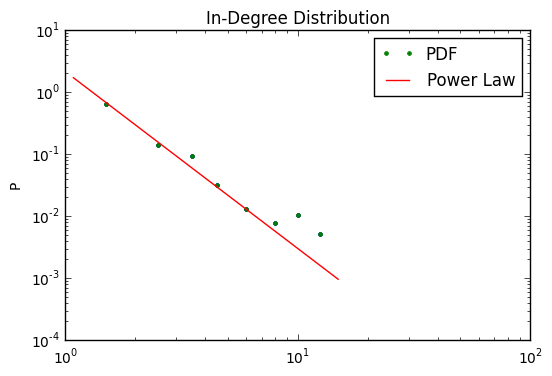

In [27]:
import powerlaw as pl
fit = pl.Fit(net_test_data['ind'])
fit.plot_pdf(linestyle = 'none', marker = '.')

print fit.distribution_compare('power_law', 'exponential')
print fit.distribution_compare('power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'power_law')

fit.plot_pdf(linestyle = 'none', marker = '.', label = 'PDF')
#fit.truncated_power_law.plot_pdf(label = 'TPL')
#fit.lognormal.plot_pdf(label = 'Lognormal')
fit.power_law.plot_pdf(label = 'Power Law')
plt.legend()
plt.title('In-Degree Distribution')
plt.ylabel('P')

Calculating best minimal value for power law fit


(11.04833434809002, 0.00047274976528888007)
(-0.46219234390878761, 0.10879399872859997)
(-0.46219280530648754, 0.10808438335575048)
(-4.6139769993569502e-07, 0.99923353433429596)


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


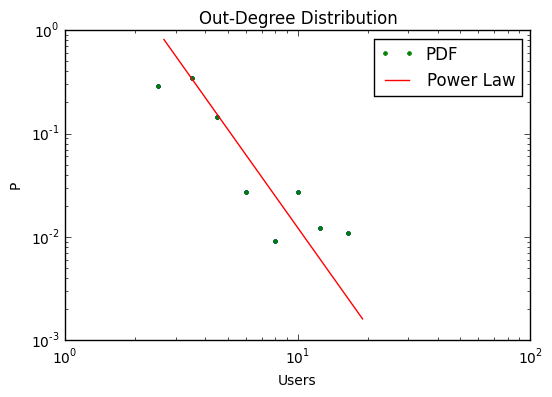

In [28]:
import powerlaw as pl
fit = pl.Fit(net_test_data['outd'])
fit.plot_pdf(linestyle = 'none', marker = '.')

print fit.distribution_compare('power_law', 'exponential')
print fit.distribution_compare('power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'power_law')



fit.plot_pdf(linestyle = 'none', marker = '.', label = 'PDF')
#fit.truncated_power_law.plot_pdf(label = 'TPL')
#fit.lognormal.plot_pdf(label = 'Lognormal')
fit.power_law.plot_pdf(label = 'Power Law')
plt.legend()
plt.title('Out-Degree Distribution')
plt.xlabel('Users')
plt.ylabel('P')

Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


(95.506940149960258, 1.1595364289835682e-09)
(-0.18444888432159667, 0.45808266671476372)
(-0.1844633486477959, 0.46565987755740945)
(-1.4464326199226107e-05, 0.99570856964202792)


Assuming nested distributions


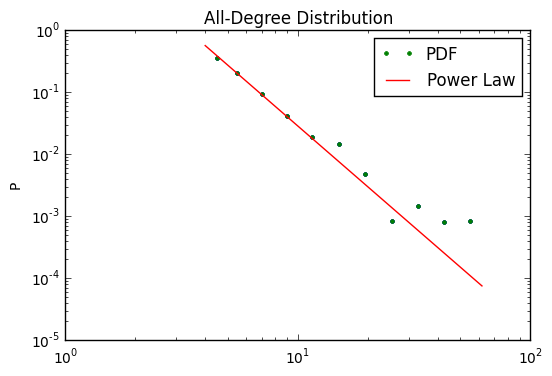

In [29]:
import powerlaw as pl
fit = pl.Fit(net_test_data['dgree'])
fit.plot_pdf(linestyle = 'none', marker = '.')

print fit.distribution_compare('power_law', 'exponential')
print fit.distribution_compare('power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'lognormal')
print fit.distribution_compare('truncated_power_law', 'power_law')

'''R is the loglikelihood ratio between the two candidate distributions. 
This number will be positive if the data is more likely in the first distribution, 
and negative if the data is more likely in the second distribution. 
The significance value for that direction is p.
'''
fit.plot_pdf(linestyle = 'none', marker = '.', label = 'PDF')
#fit.truncated_power_law.plot_pdf(label = 'TPL')
#fit.lognormal.plot_pdf(label = 'Lognormal')
fit.power_law.plot_pdf(label = 'Power Law')
plt.legend()
plt.title('All-Degree Distribution')
plt.ylabel('P')

In [31]:
#LR
from sklearn.linear_model import LogisticRegression

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X_train, Y_train)

# check the accuracy on the training set
model.score(X_train, Y_train)

0.97515968772178852